# **Deep Learning Group Project: Eye Disease Classification**
**Master's  Degree Program in Data Science and Advanced Analytics, with a specialization in Data Science (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>


### **Group Information**

*   André Cunha, 20191224 - r20191224@novaims.unl.pt
*   Catarina Duarte, 20191211 - r20191211@novaims.unl.pt
*   Cláudia Rocha, 20191249 - r20191249@novaims.unl.pt
*   Dinis Melo, 20191190 - r20191190@novaims.unl.pt
*   Susana Dias, 20220198 - 20220198@novaims.unl.pt

### **Data Source** 

 
Kaggle dataset:
https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification


Link to the prepared dataset: https://drive.google.com/drive/folders/1HEti1Qv_-iXiOf2zp2amG8XFgk-HPuLj?usp=sharing


### **Main Steps** 


*   Explore the type of images there are in the dataset
*   Understand the composition of the dataset (landscape, vertical or squared images)
*   Splitting the train dataset into train and validation batches



### **Context of the Problem**

The field of medical diagnosis has always been challenging due to the complexity and diversity of human diseases. With the rise of Artificial Intelligence techniques, it has become possible to automate and optimize the process of diagnosis by leveraging large amounts of medical data.

Regarding the field of ophthalmology, early detection and accurate diagnosis of eye diseases are critical to ensuing timely treatment and preverting vision loss. However, distinguishing between these diseases can be a challenging task. Our goal is to develop a deep learning model that can accurately classify 3 eye diseases - cataracts, glaucoma and diabetic retinopathy - and a no-disease eye - normal eye - based on a dataset of aproximatelly 1000 images of human retinal for each class.


# **Import the Needed Libraries**

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from sklearn.metrics import confusion_matrix
import os
import time
import shutil
import random 
import zipfile
import cv2

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap


# **Data Exploration**

Firstly, we will connect the machine to our dataset, and then explore the composition of our dataset, taking a look on each class sample of images.

The used dataset consists in Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class has, respectively, 1074, 1098, 1038 and 1007 files. The first step in the data exploration was to create a python notebook to (*is to import those images to the notebook and*) split the dataset into train and test, it can be found in the folder with the name "dataset_preparation". Following, we selected 4 random images from each category in the training folder to display the images and their corresponding tuple of a 3-dimensional array (e.g. (256, 256, 3)) that represents height, width and the color channels. It is noticeable to see that the pixels of the images differ. 


Setting the connection to the data source.

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Nova IMS/Projeto DL/"
main_folder, training_folder, testing_folder = "dataset_prepared/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'dataset_prepared.zip', 'dataset_prepared.zip')
    # Extract files
    zip_ = zipfile.ZipFile('dataset_prepared.zip')
    zip_.extractall()
    zip_.close()
    # Checking how much time did it take to transfer the file
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 14.764 seconds


Taking a look on each single data instance (images). For that, we'll create a funtion that allow us to input the *main folder* directory, and the name of the class, and it will return a sample of images of that inputed class.

In [ ]:
# Defining a function to show a sample of images
# The function will take 2 inputs: the directory and the class (folder)

def show_sample_images(folder_directory, class_): 
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_))
        plt.axis("off")

**Cataract**

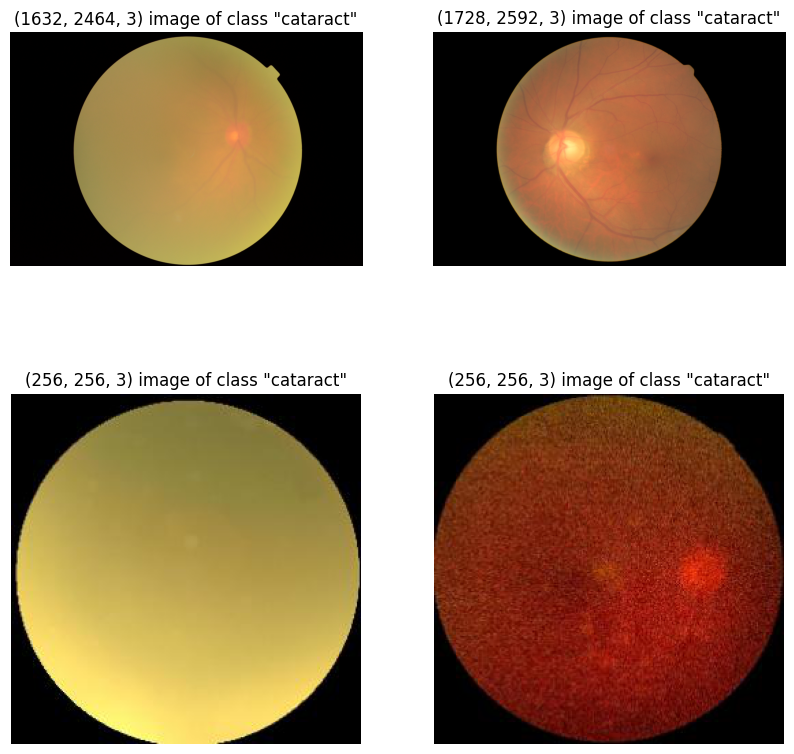

In [ ]:
# Checking the cataract images
show_sample_images(path + main_folder + training_folder, "cataract")

**Diabetic Retinopathy**

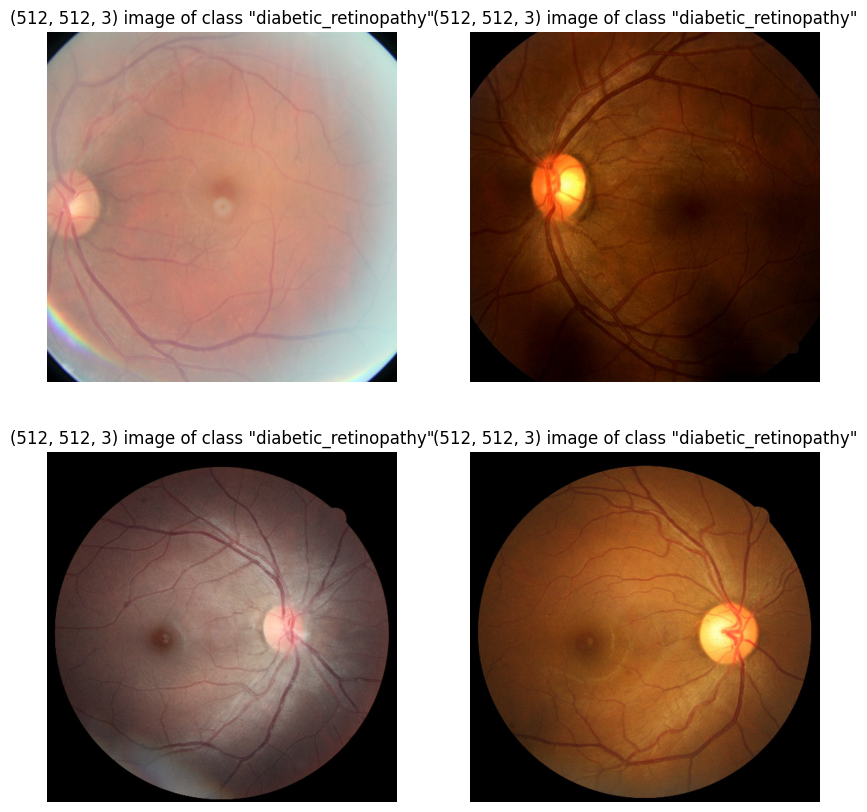

In [ ]:
# Checking the Diabetic Retinopathy images
show_sample_images(path + main_folder + training_folder, "diabetic_retinopathy")

**Glaucoma**

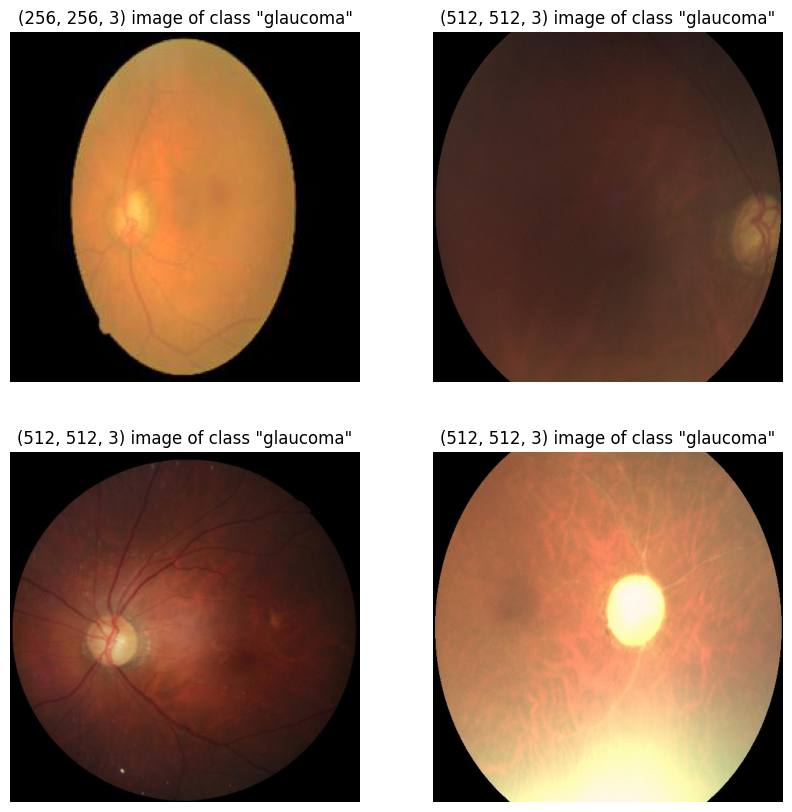

In [ ]:
# Checking the Glaucoma images
show_sample_images(path + main_folder + training_folder, "glaucoma")

**Normal**

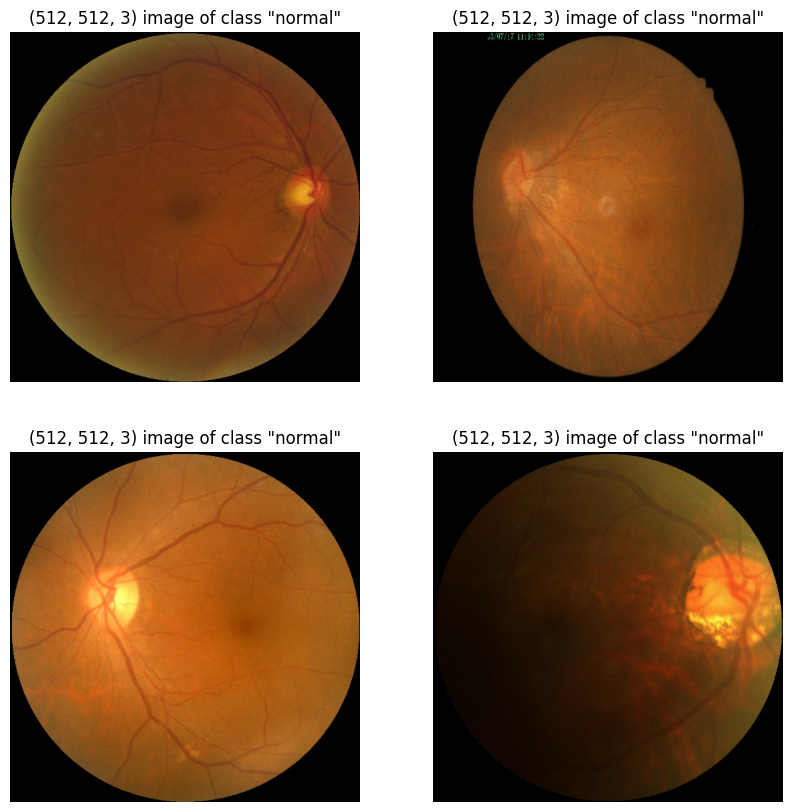

In [ ]:
# Cheking the Normal eyes images (no disease)
show_sample_images(path + main_folder + training_folder, "normal")

In [ ]:
# Checking the image data format convention used
tf.keras.backend.image_data_format()

'channels_last'

After inspectioning the previous images, we can conclude that most images are squares, but with different sizes [(256,256) or (512,512)]. However, to confirm that, we'll do further analysis on that. 

In addition, when checking the image data format convention used - with the `image_data_format()` function, and getting **channels_last** as output, we understand thatthe output is (H,W,C), therefore the number of color channels in the images are mostly 3 (R,G,B).

We'll procceed with checking the classes' balance with bar plots and charts.

In [ ]:
# Creating a for loop to check each classes' balance
for split in [training_folder, testing_folder]: # Iterating through each folder
    for c in ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']: # Iterating through each disease
        n_train_c = len(os.listdir(path + main_folder + split + f"/{c}")) # Couting the nr. of instances on each disease
        # Print the number of instancer on each class
        print(f"Nº of instances of class {c} in the {split}: {n_train_c}")
    print(' ')

Nº of instances of class cataract in the train/: 830
Nº of instances of class diabetic_retinopathy in the train/: 878
Nº of instances of class glaucoma in the train/: 805
Nº of instances of class normal in the train/: 860
 
Nº of instances of class cataract in the test/: 208
Nº of instances of class diabetic_retinopathy in the test/: 220
Nº of instances of class glaucoma in the test/: 202
Nº of instances of class normal in the test/: 214
 


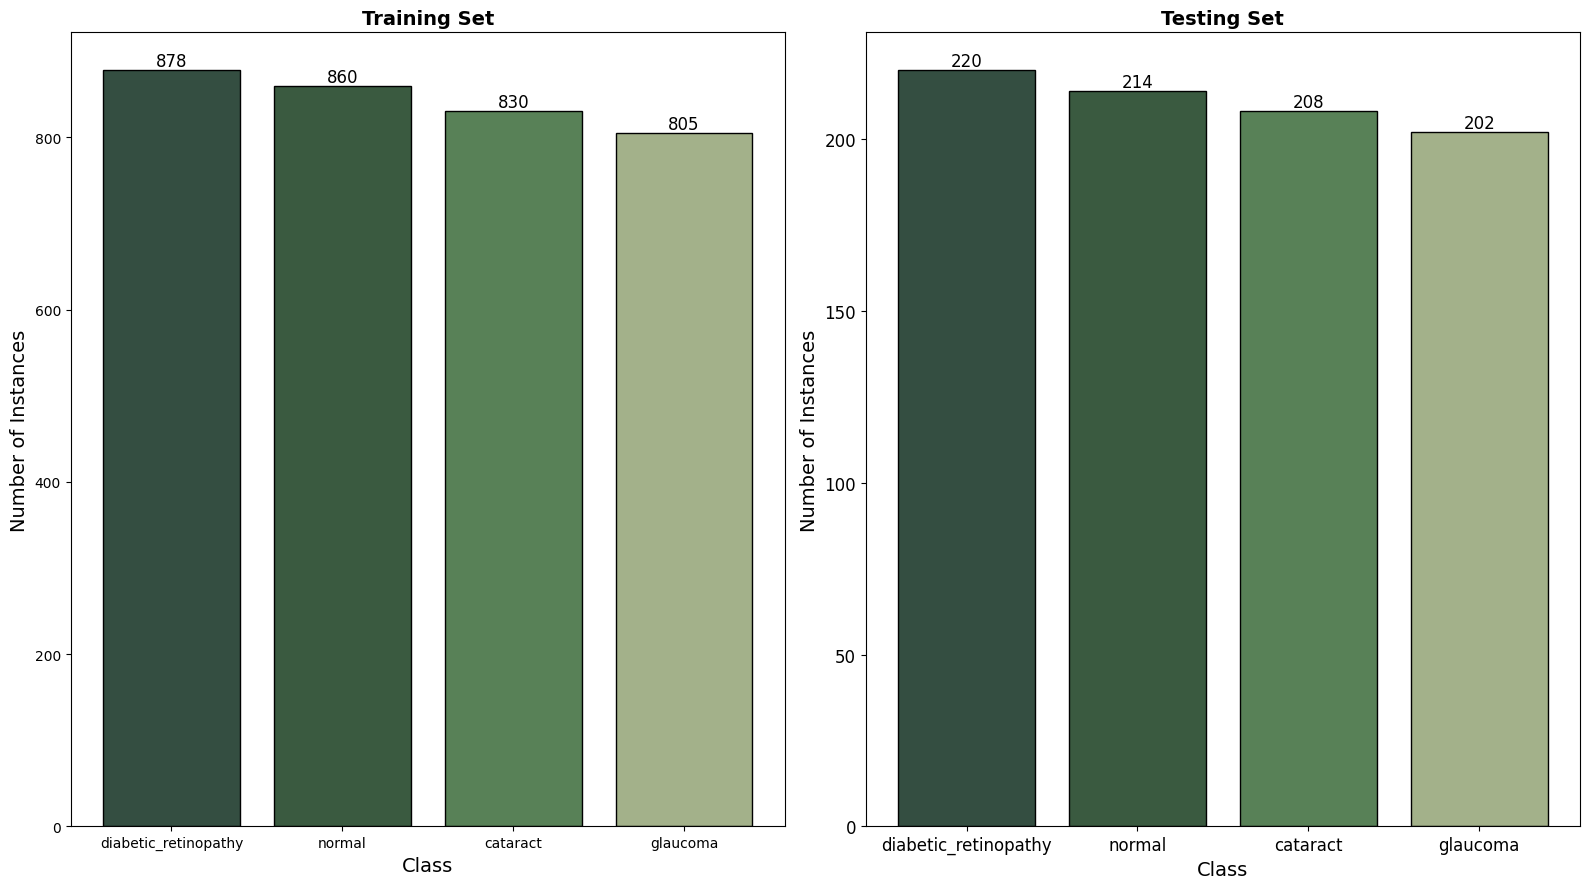

In [ ]:
# Create a dictionary to store the number of instances for each class in the training and testing sets
train_counts = {}
test_counts = {}

colors = ['#344e41', '#3a5a40', '#588157', '#a3b18a']  # specify colors

# Loop through the subdirectories for each class in the training set
for c in ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']:
    n_train_c = len(os.listdir(path + main_folder + training_folder + f"/{c}"))
    train_counts[c] = n_train_c

# Loop through the subdirectories for each class in the testing set
for c in ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']:
    n_test_c = len(os.listdir(path + main_folder + testing_folder + f"/{c}"))
    test_counts[c] = n_test_c

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 9))

# Plot the training set class counts as a bar chart
train_count_sorted = dict(sorted(train_counts.items(), key=lambda x: x[1], reverse=True))
train_bars = ax1.bar(train_count_sorted.keys(), train_count_sorted.values(), color=colors, edgecolor='black', linewidth=1)
ax1.set_title('Training Set', fontweight="bold", fontsize=14)
ax1.set_xlabel('Class', fontsize=14)
ax1.set_ylabel('Number of Instances', fontsize=14)

# Plot the testing set class counts as a bar chart
test_count_sorted = dict(sorted(test_counts.items(), key=lambda x: x[1], reverse=True))
test_bars = ax2.bar(test_count_sorted.keys(), test_count_sorted.values(), color=colors, edgecolor='black', linewidth=1)
ax2.set_title('Testing Set', fontweight="bold", fontsize=14)
ax2.set_xlabel('Class', fontsize=14)
ax2.set_ylabel('Number of Instances', fontsize=14)

# Add grid lines to the plots
#ax1.grid(axis='y', linestyle='--', alpha=0.7, color="black")
#ax2.grid(axis='y', linestyle='--', alpha=0.7, color="black")

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the exact number of instances for each class to the training set bar chart
for i, v in enumerate(train_count_sorted.values()):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

# Add the exact number of instances for each class to the testing set bar chart
for i, v in enumerate(test_count_sorted.values()):
    ax2.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

# Adjust the layout of the figure
fig.tight_layout()

# Display the figure
plt.show()


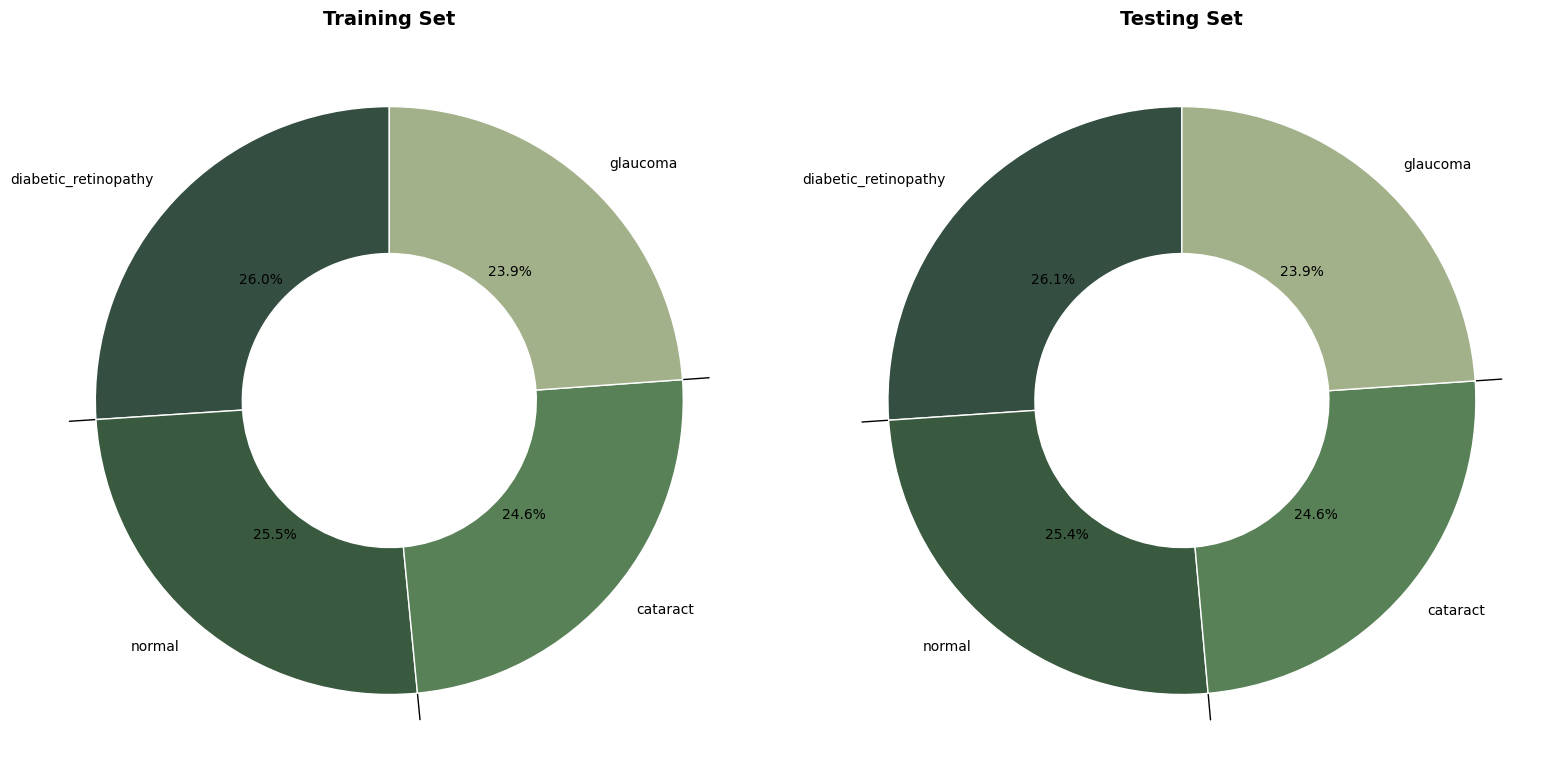

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 9))

# Plot the training set class counts as a pie chart
train_count_sorted = dict(sorted(train_counts.items(), key=lambda x: x[1], reverse=True))
wedges, texts, autotexts = ax1.pie(train_count_sorted.values(), labels=train_count_sorted.keys(), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5, edgecolor='white'))
for i in range(len(wedges)):
    wedges[i].set_edgecolor('white')
    wedges[i].set_facecolor(colors[i])
    wedges[i].set_linewidth(1)

# Add delimiters between the pie slices
for i in range(len(wedges)-1):
    angle = (wedges[i].theta2 + wedges[i+1].theta1) / 2
    ax1.annotate("", xytext=(0.9*np.cos(np.radians(angle)), 0.9*np.sin(np.radians(angle))), xy=(1.1*np.cos(np.radians(angle)), 1.1*np.sin(np.radians(angle))), arrowprops=dict(arrowstyle='-', linewidth=1, color='black'), zorder=0)

ax1.set_title('Training Set', fontweight="bold", fontsize=14)

# Plot the testing set class counts as a pie chart
test_count_sorted = dict(sorted(test_counts.items(), key=lambda x: x[1], reverse=True))
wedges, texts, autotexts = ax2.pie(test_count_sorted.values(), labels=test_count_sorted.keys(), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5, edgecolor='white'))
for i in range(len(wedges)):
    wedges[i].set_edgecolor('white')
    wedges[i].set_facecolor(colors[i])
    wedges[i].set_linewidth(1)

# Add delimiters between the pie slices
for i in range(len(wedges)-1):
    angle = (wedges[i].theta2 + wedges[i+1].theta1) / 2
    ax2.annotate("", xytext=(0.9*np.cos(np.radians(angle)), 0.9*np.sin(np.radians(angle))), xy=(1.1*np.cos(np.radians(angle)), 1.1*np.sin(np.radians(angle))), arrowprops=dict(arrowstyle='-', linewidth=1, color='black'), zorder=0)

ax2.set_title('Testing Set', fontweight="bold", fontsize=14)

# Adjust the layout of the figure
fig.tight_layout()


When checking the number of instances in the training and testing datasets, we can conclude that it is slightly imbalanced. 

The number of instances for each class in the training set ranges from 805 to 878, with a difference of 73 instances between the most and least represented classes. Similarly, the number of instances for each class in the test set ranges from 202 to 220, with a difference of 18 instances between the most and least represented classes. 

Visually, the difference is not very evident, as seen in the bar plot and donut chart. We considered this would not be a problem in our model construction so we chose not to apply under sampling techniques.

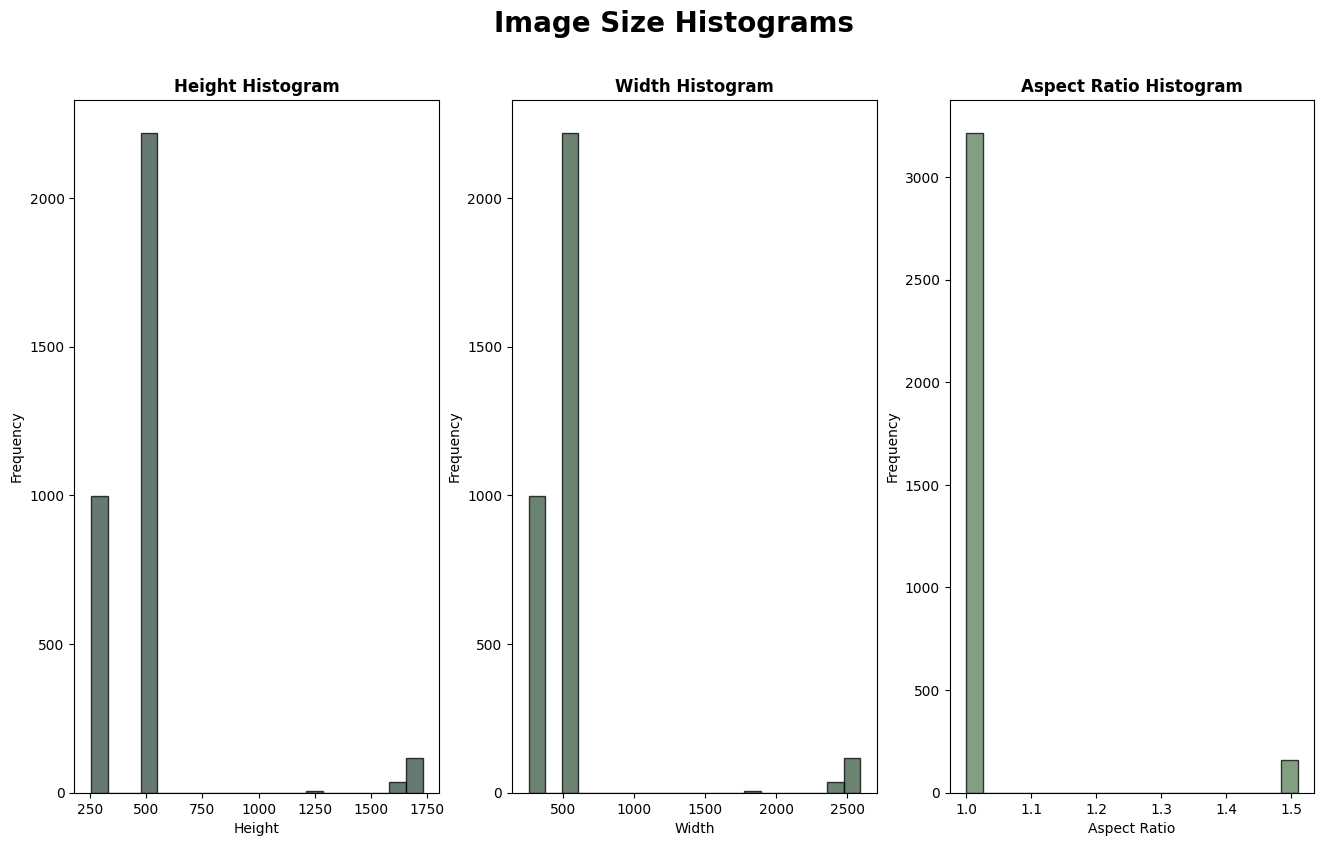

In [ ]:
# Load and read images using OpenCV
images = []
for c in ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']:
    folder_path = path + main_folder + training_folder + f"/{c}"
    for file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        images.append(img)

# Compute aspect ratios for each image
aspect_ratios = []
heights = []
widths = []
for img in images:
    h, w, _ = img.shape
    aspect_ratio = w / h
    aspect_ratios.append(aspect_ratio)
    heights.append(h)
    widths.append(w)

# Plot histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 9))
n_bins = 20
histtype = 'bar'
alpha = 0.75
density = False
edgecolor = 'black'

# Height histogram
ax[0].hist(heights, bins=n_bins, histtype=histtype, alpha=alpha, density=density, color=colors[0], edgecolor=edgecolor)
ax[0].set_title('Height Histogram', fontweight="bold")
ax[0].set_xlabel('Height')
ax[0].set_ylabel('Frequency')

# Width histogram
ax[1].hist(widths, bins=n_bins, histtype=histtype, alpha=alpha, density=density, color=colors[1], edgecolor=edgecolor)
ax[1].set_title('Width Histogram', fontweight="bold")
ax[1].set_xlabel('Width')
ax[1].set_ylabel('Frequency')

# Aspect ratio histogram
ax[2].hist(aspect_ratios, bins=n_bins, histtype=histtype, alpha=alpha, density=density, color=colors[2], edgecolor=edgecolor)
ax[2].set_title('Aspect Ratio Histogram', fontweight="bold")
ax[2].set_xlabel('Aspect Ratio')
ax[2].set_ylabel('Frequency')

plt.suptitle('Image Size Histograms', fontsize=20, fontweight="bold")
plt.show()


Through these graphs, we can understand that the majority of our images are squares, since the aspect ratio is 1.

The most frequent **height** is about 500 pixels, followed by a value smaller than this. As said before, and since the majority of our images are squares, the most frequent **width** is also about 500 pixels.

Now, let's define a list of parameters for the `image_dataset_from_directory`.

In [ ]:
# Defining the parameters 
# Image size as a square with 128 x 128 pixels
image_size=(128, 128) 
# Crop the image to maintain the aspect ratio specified in image_size
crop_to_aspect_ratio=True
# Using the RGB channel
color_mode='rgb'
# Nr of samples to include on each batch
batch_size=64
# Categorical since we have 4 classes, and they'll be encoded
label_mode="categorical"
# 20% of data for validation
validation_split=0.2
shuffle=True
seed=0

Using the previously defined parameters, now let's create two objects - `ds_train`and `ds_val` - one for train and one for validation. These objects are created by just assigning a value to the `validation_split` parameter, which, in this case, is 20%.

In [ ]:
# Generate an object of type tf.data.Dataset 
# Using the previously defined parameters
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 3373 files belonging to 4 classes.
Using 2699 files for training.
Using 674 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


Now, let's generate a batch of training data from the `ds_train` object using the  `iter_train.next()` function, which generates the next batch of data from the iterator. Let's also check information about the generated batch. 

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
# The batch_x_train contains the input images for the batch, and the batch_y_train contains the corresponding labels
# Printing the shapes of those batches
print(batch_x_train.shape, batch_y_train.shape) 
# Printing a sample of the first image
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
# Printing the first five labels in the batch
print("\nSample of y_train:", batch_y_train[0:5])
# Printing the average value of the labels in the batch
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 128, 128, 3) (64, 4)

Sample of x_train: tf.Tensor(
[[0. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]], shape=(5, 4), dtype=float32)
Sample average of y_train: tf.Tensor(0.25, shape=(), dtype=float32)


Finally, similarly to what was previously done in the exploration part of the images for each class, let's check the images loaded with `BatchDataset`. In the batch, there will be images from the different classes.

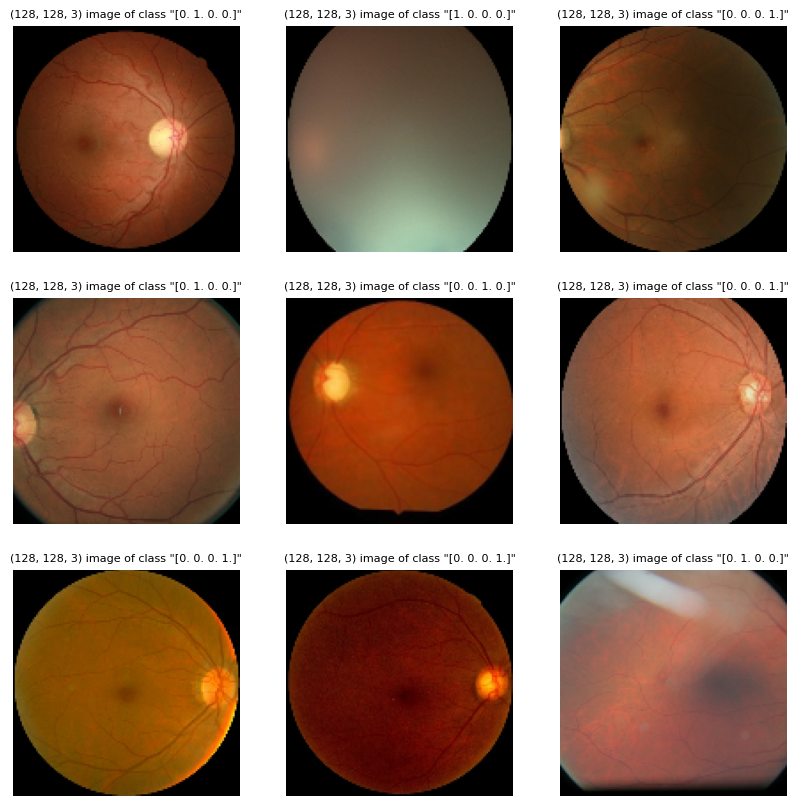

In [ ]:
# Defining a function to print the images from a batch
# Takes 2 inputs: the batch from which we want to check the images, and the grid size. The default value for the grid_size is (3,3)
def show_sample_batch(ds, grid_size=(3, 3)): 
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

# Calling the previously created function, checking images of the train batch
show_sample_batch(ds_train)

Loads the testing data using the `image_dataset_from_directory()` function, similarly to what was done with the `ds_train` and `ds_val`.

In [ ]:
# Creating the test batch, using the parameter defined before as well as the path to the testing folder.
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)
# Note that this batch doesn't have the validation_split parameter (since we do not want to split the testing data)

Found 844 files belonging to 4 classes.
